#Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import brentq

#Function definition

In [2]:
def get_options(ticker, start_date, finish_date,valuation_date):
  start_date=pd.to_datetime(start_date,format="%m/%d/%Y")
  finish_date=pd.to_datetime(finish_date,format="%m/%d/%Y")
  #trade_date=pd.to_datetime(trade_date,format="%m/%d/%Y")
  valuation_date=pd.to_datetime(valuation_date)
  Ticker=yf.Ticker(ticker)
  exp_date=pd.to_datetime(Ticker.options)
  valid_expires=exp_date[(exp_date>=start_date)&(exp_date<=finish_date)]
  options_data=[]

  Underlying=Ticker.fast_info['last_price']
  if Underlying is None:
    Underlying=Ticker.history(period="1d").iloc[-1]

  for expiry in valid_expires:
    chain=Ticker.option_chain(expiry.strftime("%Y-%m-%d"))
    dte=max(1/365,(expiry-valuation_date).days/365)
    calls=chain.calls.assign(expiry=expiry,type="call",Spot=Underlying,T=dte)
    puts=chain.puts.assign(expiry=expiry,type="put",Spot=Underlying,T=dte)
    options_data.append(pd.concat([calls,puts],ignore_index=True))

  df = pd.concat(options_data, ignore_index=True)
  df["valuation_date"] = valuation_date
  return df

In [33]:
def d1_d2(S,K,r,q,sigma,T):
  #d1=(np.log(S/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
  d1=(np.log(S/K)+(r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
  #d2=d1-sigma*np.sqrt(T
  d2=d1-sigma*np.sqrt(T)
  return d1,d2

def vega(S,K,r,q,sigma,T):
  #return S*np.sqrt(T)*norm.pdf(d1_d1(S,K,r,sigma,T)[0])
  return S*np.exp(-q*T)*np.sqrt(T)*norm.pdf(d1_d2(S,K,r,q,sigma,T)[0])

def C_bs(S,K,r,q,sigma,T):
  #return S*norm.cdf(d1_d1(S,K,r,sigma,T)[0])-K*np.exp(-r*T)*norm.cdf(d1_d1(S,K,r,sigma,T)[1])
  return S*np.exp(-q*T)*norm.cdf(d1_d2(S,K,r,q,sigma,T)[0])-K*np.exp(-r*T)*norm.cdf(d1_d2(S,K,r,q,sigma,T)[1])

def P_bs(S,K,r,q,sigma,T):
  #return K*np.exp(-r*T)*norm.cdf(-d1_d1(S,K,r,sigma,T)[1])-S*norm.cdf(-d1_d1(S,K,r,sigma,T)[0])
  return K*np.exp(-r*T)*norm.cdf(-d1_d2(S,K,r,q,sigma,T)[1])-S*np.exp(-q*T)*norm.cdf(-d1_d2(S,K,r,q,sigma,T)[0])

def iv(initial_guess,mkt_price,S,K,r,q,T,c_p,tol=1e-6,max_iter=50):
  def price_diff(sigma):
    if c_p=='call':
      return C_bs(S,K,r,q,sigma,T)-mkt_price
    else:
      return P_bs(S,K,r,q,sigma,T)-mkt_price
  lower_bound,higher_bound=1e-6,20

  try:
    if price_diff(lower_bound)*price_diff(higher_bound)>0:
      return np.nan
    return brentq(price_diff,lower_bound,higher_bound,xtol=tol,maxiter=max_iter)
  except Exception:
    return np.nan


''' sigma=initial_guess #newton rapshon
  for i in range(max_iter):
    if c_p=='call':
      price=C_bs(S,K,r,sigma,T)
    else:
      price=P_bs(S,K,r,sigma,T)
    Vega=vega(S,K,r,sigma,T)

    if Vega < 1e-8:
      return np.nan
    diff=price-mkt_price
    if abs(diff)<tol:
      return sigma
    sigma = max(1e-6, sigma - diff/Vega)
   return sigma'''

" sigma=initial_guess #newton rapshon\n  for i in range(max_iter):\n    if c_p=='call':\n      price=C_bs(S,K,r,sigma,T)\n    else:\n      price=P_bs(S,K,r,sigma,T)\n    Vega=vega(S,K,r,sigma,T)\n\n    if Vega < 1e-8:\n      return np.nan\n    diff=price-mkt_price\n    if abs(diff)<tol:\n      return sigma\n    sigma = max(1e-6, sigma - diff/Vega)\n   return sigma"

#Variable set up

In [44]:

start_date  = "04/23/2025"
finish_date = "12/20/2030"
expiry_selected="2026-01-20"#Expiration date i want to perform the analysis on
#trade_date="04/23/2025"
div_yield=0.013
ticker = "^SPX"
valuation_date = pd.Timestamp("2026-01-16")

snapshot_file = f"{ticker}_options_{valuation_date.date()}.parquet"

try:
    options_list = pd.read_parquet(snapshot_file)
except FileNotFoundError:
    options_list = get_options(ticker, start_date, finish_date, valuation_date)
    options_list.to_parquet(snapshot_file)

# recover valuation_date from file (so you can’t accidentally mismatch later)
valuation_date = pd.to_datetime(options_list["valuation_date"].iloc[0])

#options_list=get_options(ticker,start_date,finish_date,valuation_date)
sofr={
    "Term": ["1 Year", "2 Year", "3 Year", "5 Year", "7 Year", "10 Year", "15 Year", "30 Year"],
    "GG": [365, 730, 1095, 1825, 2555, 3650, 5475, 10950],
    "Rate": [0.0376, 0.0345, 0.0341, 0.0351, 0.0363, 0.0378, 0.0395, 0.0392]
}
sofr_df=pd.DataFrame(sofr)

#Database set up

In [45]:
OTM_options = options_list.loc[options_list["inTheMoney"] == False].copy()
OTM_options['rf']=np.interp(OTM_options['T']*365,sofr_df['GG'],sofr_df['Rate'])
OTM_options['mid']=(OTM_options['bid']+OTM_options['ask'])/2

OTM_options = OTM_options[
    (OTM_options["T"] > 0) &
    (OTM_options["mid"] > 0.05) &
    ((OTM_options["volume"] > 0) | (OTM_options["openInterest"] > 10)) &
    (OTM_options["rf"].notna())
].copy()

OTM_options['moneyness']=OTM_options['strike']/OTM_options['Spot']
OTM_options=OTM_options[
    (OTM_options['moneyness'] > 0.5) &  #removing deep otm
    (OTM_options['moneyness'] < 2.0)
].copy()

OTM_options['q']=div_yield
theor_iv=OTM_options.apply(
    lambda row: iv(0.2,row['mid'],row['Spot'],row['strike'],row['rf'],row['q'],row['T'],row['type']),axis=1
)


In [46]:
OTM_options['calculated_iv']=theor_iv
comparison_df=OTM_options.dropna(subset=['calculated_iv','impliedVolatility']).copy()

In [47]:
cols_to_keep = ['expiry', 'type', 'strike', 'Spot','rf','q', 'T', 'mid', 'impliedVolatility', 'calculated_iv']
comparison_df = comparison_df[cols_to_keep].copy()
comparison_df['diff_bps'] = (comparison_df['calculated_iv'] - comparison_df['impliedVolatility']) * 10000

comparison_df.head()

,expiry,type,strike,Spot,rf,q,T,mid,impliedVolatility,calculated_iv,diff_bps
75,2026-01-20,call,6945.0,6940.009766,0.0376,0.013,0.010959,17.65,0.080423,0.066130,-142.928139
76,2026-01-20,call,6950.0,6940.009766,0.0376,0.013,0.010959,15.00,0.078798,0.064765,-140.333767
77,2026-01-20,call,6955.0,6940.009766,0.0376,0.013,0.010959,12.55,0.076700,0.063318,-133.815952
78,2026-01-20,call,6960.0,6940.009766,0.0376,0.013,0.010959,10.35,0.074907,0.061938,-129.694574
79,2026-01-20,call,6965.0,6940.009766,0.0376,0.013,0.010959,8.40,0.073435,0.060607,-128.273578


In [48]:
comparison_target=comparison_df[comparison_df['expiry']==pd.to_datetime(expiry_selected)].copy()

In [49]:
comparison_target.head()

,expiry,type,strike,Spot,rf,q,T,mid,impliedVolatility,calculated_iv,diff_bps
75,2026-01-20,call,6945.0,6940.009766,0.0376,0.013,0.010959,17.65,0.080423,0.066130,-142.928139
76,2026-01-20,call,6950.0,6940.009766,0.0376,0.013,0.010959,15.00,0.078798,0.064765,-140.333767
77,2026-01-20,call,6955.0,6940.009766,0.0376,0.013,0.010959,12.55,0.076700,0.063318,-133.815952
78,2026-01-20,call,6960.0,6940.009766,0.0376,0.013,0.010959,10.35,0.074907,0.061938,-129.694574
79,2026-01-20,call,6965.0,6940.009766,0.0376,0.013,0.010959,8.40,0.073435,0.060607,-128.273578


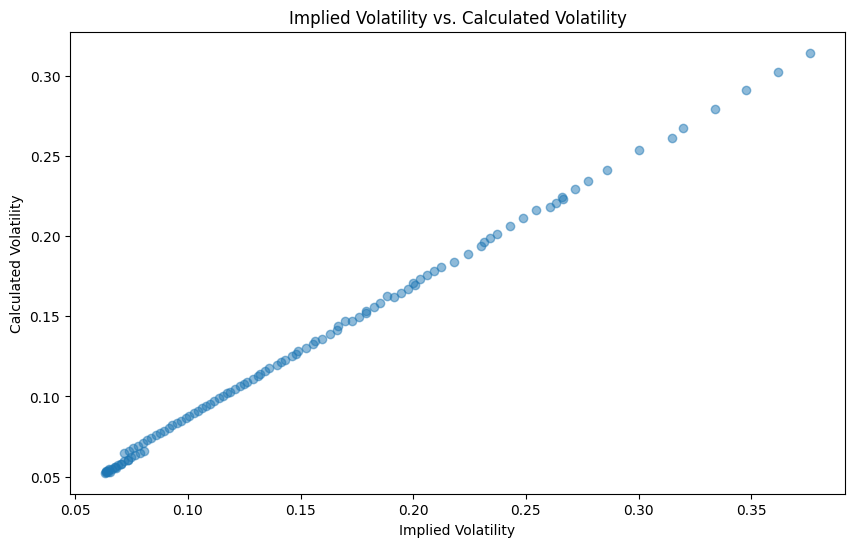

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(comparison_target['impliedVolatility'], comparison_target['calculated_iv'], alpha=0.5)
plt.xlabel('Implied Volatility')
plt.ylabel('Calculated Volatility')
plt.title('Implied Volatility vs. Calculated Volatility')
plt.show()

In [51]:
comparison_target[
    (comparison_target["impliedVolatility"] < 0.08) &
    (comparison_target["calculated_iv"] < 0.06)
][[
    "type", "strike", "mid",
    "impliedVolatility", "calculated_iv","Spot"
]].sort_values("strike")


,type,strike,mid,impliedVolatility,calculated_iv,Spot
80,call,6970.0,6.750,0.071840,0.059542,6940.009766
81,call,6975.0,5.250,0.070108,0.058129,6940.009766
82,call,6980.0,4.050,0.068834,0.057073,6940.009766
83,call,6985.0,3.075,0.067575,0.056146,6940.009766
84,call,6990.0,2.250,0.066080,0.054998,6940.009766
85,call,6995.0,1.675,0.064813,0.054501,6940.009766
86,call,7000.0,1.175,0.064218,0.053514,6940.009766
87,call,7005.0,0.825,0.063608,0.052877,6940.009766
88,call,7010.0,0.575,0.063303,0.052418,6940.009766
89,call,7015.0,0.425,0.063852,0.052674,6940.009766


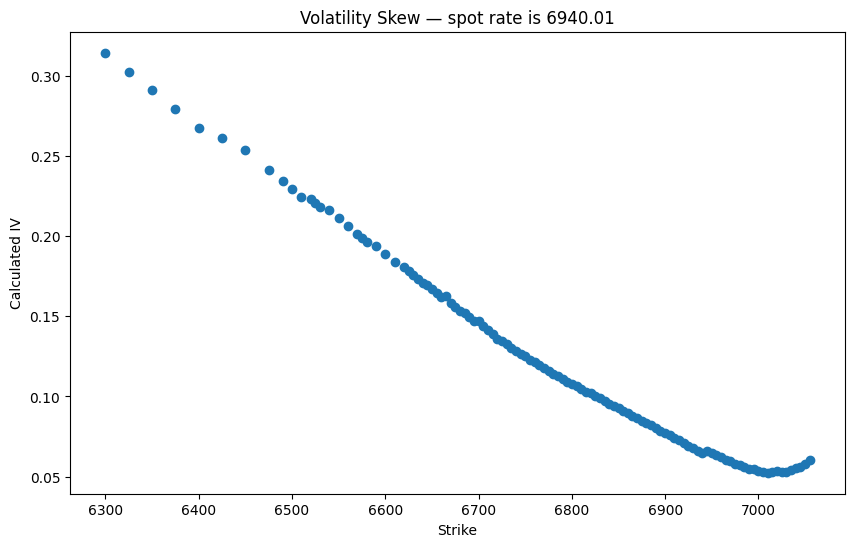

In [56]:
plt.figure(figsize=(10, 6))
plt.scatter(comparison_target['strike'],comparison_target['calculated_iv'])
plt.xlabel('Strike')
plt.ylabel('Calculated IV')
plt.title(f"Volatility Skew — spot rate is {comparison_target['Spot'].iloc[0]:.2f}")
plt.show()